<a href="https://colab.research.google.com/github/JSJeong-me/deepfashion2-/blob/main/deepfashion-0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/red-buffer/training-an-object-detection-model-in-a-few-minutes-using-detectron2-5bd0aa5550d4

In [ ]:
!pwd

In [ ]:
!nvcc --version

In [ ]:
import torch

In [ ]:
torch.__version__

In [ ]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

Restart kernel

Downloading Dataset

Data set url -> https://drive.google.com/drive/folders/125F48fsMBz2EF0Cpqk6aaHet5VH399Ok



In [2]:
#!mkdir /content/DeepFashion2/
!cp /content/drive/MyDrive/deepfashion2/validation.zip /content/DeepFashion2/

In [3]:
!pwd

/content


In [4]:
!ls -l

total 12
drwxr-xr-x 2 root root 4096 Nov  2 03:36 DeepFashion2
drwx------ 6 root root 4096 Nov  2 03:22 drive
drwxr-xr-x 1 root root 4096 Oct 26 13:34 sample_data


In [ ]:
!unzip -P "2019Deepfashion2**" /content/DeepFashion2/validation.zip -d /content/DeepFashion2/

In [6]:
!ls /content/DeepFashion2/validation/image | wc -l
!ls /content/DeepFashion2/validation/annos | wc -l

32153
32153


DeepFashion2 dataset을 Deepfashion2 github에서 제공하는 deepfashion2_to_coco.py파일 활용해 COCO format으로 변환

In [7]:
from PIL import Image
import numpy as np
import json

dataset = {
    "info": {},
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": []
}

lst_name = ['short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear',
            'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeved_dress',
            'long_sleeved_dress', 'vest_dress', 'sling_dress']

for idx, e  in enumerate(lst_name):
    dataset['categories'].append({
        'id': idx + 1,
        'name': e,
        'supercategory': "clothes",
        'keypoints': ['%i' % (i) for i in range(1, 295)],
        'skeleton': []
    })

num_images = 32153 #191961 
sub_index = 0  # the index of ground truth instance
for num in range(1, num_images + 1):
    json_name = '/content/DeepFashion2/validation/annos/' + str(num).zfill(6) + '.json'
    image_name = '/content/DeepFashion2/validation/image/' + str(num).zfill(6) + '.jpg'

    if (num >= 0):
        imag = Image.open(image_name)
        width, height = imag.size
        with open(json_name, 'r') as f:
            temp = json.loads(f.read())
            pair_id = temp['pair_id']

            dataset['images'].append({
                'coco_url': '',
                'date_captured': '',
                'file_name': str(num).zfill(6) + '.jpg',
                'flickr_url': '',
                'id': num,
                'license': 0,
                'width': width,
                'height': height
            })
            for i in temp:
                if i == 'source' or i == 'pair_id':
                    continue
                else:
                    points = np.zeros(294 * 3)
                    sub_index = sub_index + 1
                    box = temp[i]['bounding_box']
                    w = box[2] - box[0]
                    h = box[3] - box[1]
                    x_1 = box[0]
                    y_1 = box[1]
                    bbox = [x_1, y_1, w, h]
                    cat = temp[i]['category_id']
                    style = temp[i]['style']
                    seg = temp[i]['segmentation']
                    landmarks = temp[i]['landmarks']

                    points_x = landmarks[0::3]
                    points_y = landmarks[1::3]
                    points_v = landmarks[2::3]
                    points_x = np.array(points_x)
                    points_y = np.array(points_y)
                    points_v = np.array(points_v)
                    case = [0, 25, 58, 89, 128, 143, 158, 168, 182, 190, 219, 256, 275, 294]
                    idx_i, idx_j = case[cat - 1], case[cat]

                    for n in range(idx_i, idx_j):
                        points[3 * n] = points_x[n - idx_i]
                        points[3 * n + 1] = points_y[n - idx_i]
                        points[3 * n + 2] = points_v[n - idx_i]

                    num_points = len(np.where(points_v > 0)[0])

                    dataset['annotations'].append({
                        'area': w * h,
                        'bbox': bbox,
                        'category_id': cat,
                        'id': sub_index,
                        'pair_id': pair_id,
                        'image_id': num,
                        'iscrowd': 0,
                        'style': style,
                        'num_keypoints': num_points,
                        'keypoints': points.tolist(),
                        'segmentation': seg,
                    })

json_name = '/content/deepfashion2_validation.json'
with open(json_name, 'w') as f:
    json.dump(dataset, f)

Import packages

In [11]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [12]:
from detectron2.data.datasets import register_coco_instances
#register_coco_instances("deepfashion_train", {}, "/content/DeepFashion2/deepfashion2_train.json", "/content/DeepFashion2/train/image")

register_coco_instances("deepfashion_val", {}, "/content/DeepFashion2/deepfashion2_validation.json", "/content/DeepFashion2/validation/image")

In [ ]:
#from detectron2.data import MetadataCatalog

#MetadataCatalog.get('aquarium_train').thing_classes = ['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

Training

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("deepfashion_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00125
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Inference and Evaluation

In [20]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("deepfashion_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
!wget https://img-lcwaikiki.mncdn.com/mnresize/1024/-//productimages/20201/1/3945185/l_20201-0sg016z8-cs8_a.jpg -O /content/example.jpg

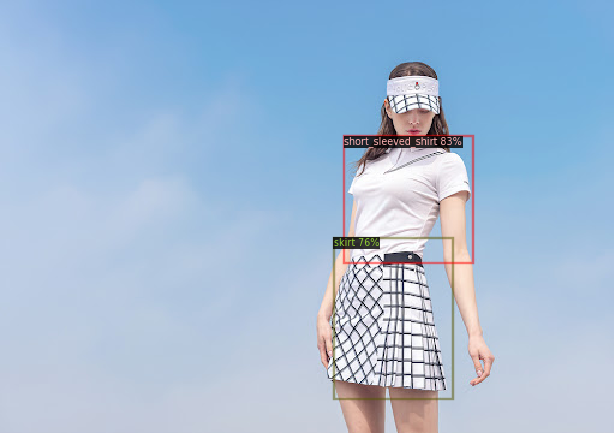

In [31]:
from detectron2.utils.visualizer import ColorMode
im = cv2.imread("/content/golfwear1.jpg")
outputs = predictor(im)
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

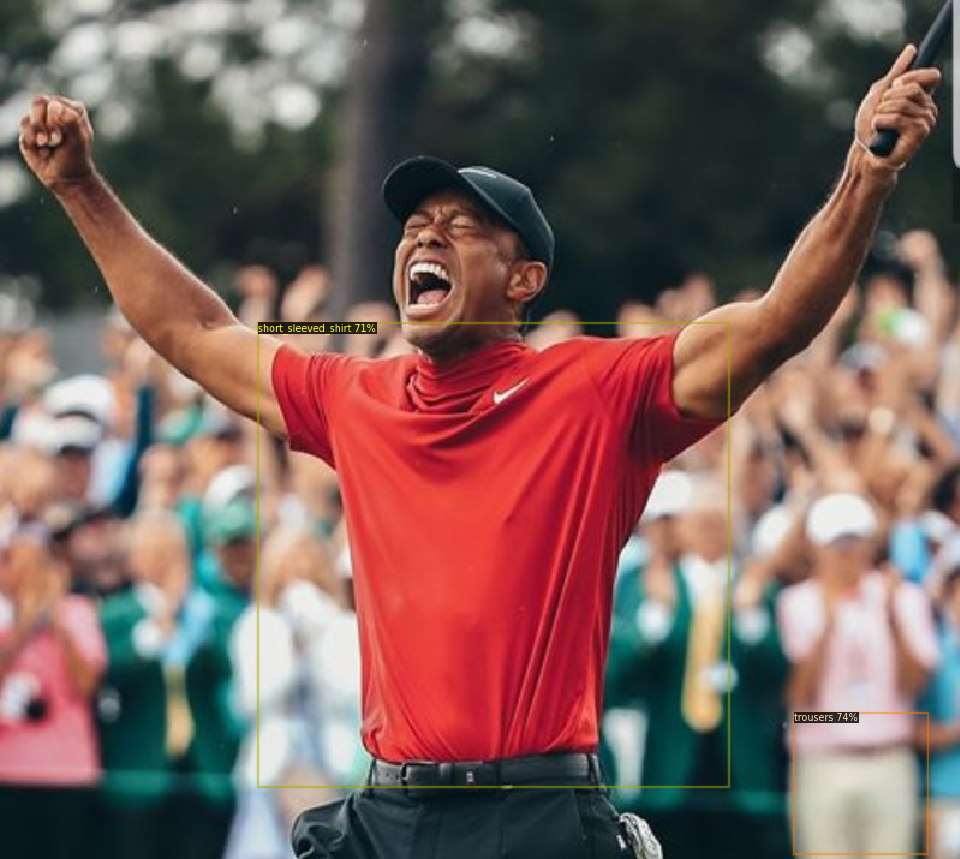

In [29]:
from detectron2.utils.visualizer import ColorMode
im = cv2.imread("/content/tiger0.jpg")
outputs = predictor(im)
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("aquarium_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "aquarium_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

Saving and reloading the model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

Saving and reloading the model

In [ ]:
import torch
new_cfg = get_cfg()
new_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
new_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
new_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
new_cfg.MODEL.WEIGHTS = "./output/model_final.pth"

In [ ]:
im = cv2.imread('/content/test/IMG_2514_jpeg_jpg.rf.19de1787caef21dba070ac1b1c78e5e0.jpg')
outputs = predictor(im)


v = Visualizer(im[:, :, ::-1],
metadata=MetadataCatalog.get('aquarium_train'),
scale=2,
instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])